In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline



/home/subash31/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
train = pd.read_csv("./train.csv")

#iteration1
train.drop('Condition2',axis=1,inplace=True)
train.drop('Street',axis=1,inplace=True)
train.drop('Alley',axis=1,inplace=True)
train.drop('LandContour',axis=1,inplace=True)
train.drop('Utilities',axis=1,inplace=True)
train.drop('LandSlope',axis=1,inplace=True)
train.drop('RoofStyle',axis=1,inplace=True)
train.drop('ExterCond',axis=1,inplace=True)
train.drop('BsmtFinType2',axis=1,inplace=True)
train.drop('Electrical',axis=1,inplace=True)
train.drop('GarageQual',axis=1,inplace=True)
train.drop('PavedDrive',axis=1,inplace=True)
train.drop('PoolQC',axis=1,inplace=True)
train.drop('Fence',axis=1,inplace=True)



test = pd.read_csv("./test.csv")

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,Condition1,BldgType,...,3SsnPorch,ScreenPorch,PoolArea,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Reg,Inside,CollgCr,Norm,1Fam,...,0,0,0,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Reg,FR2,Veenker,Feedr,1Fam,...,0,0,0,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,IR1,Inside,CollgCr,Norm,1Fam,...,0,0,0,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,IR1,Corner,Crawfor,Norm,1Fam,...,0,0,0,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,IR1,FR2,NoRidge,Norm,1Fam,...,0,0,0,NaN,0,12,2008,WD,Normal,250000


In [4]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

In [5]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [6]:
all_data = pd.get_dummies(all_data)


In [7]:
#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

In [8]:
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [9]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

In [10]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [11]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005],max_iter=1000).fit(X_train, y)

In [12]:
rmse_cv(model_lasso).mean()

0.121026996189413

In [13]:

import xgboost as xgb

/home/subash31/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [14]:
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

In [15]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv


model_xgb.fit(X_train, y)
rmse_cv(model_xgb).mean()

0.12371720115721152

In [73]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))


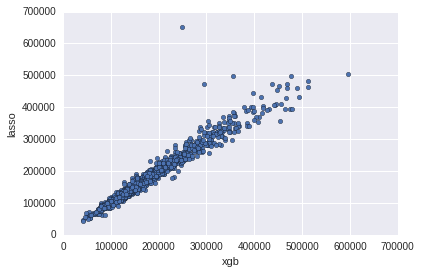

In [74]:
predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")



In [75]:


preds = 0.6*lasso_preds + 0.4*xgb_preds



In [76]:
solution = pd.DataFrame({"id":test.Id, "SalePrice":preds})
solution.to_csv("afterAttrDrop.csv", index = False)
